=== Fitted Parameters (with constraint A1/A2 = 0.49/(2*0.325)) ===
A1     = 3028.503
A2     = 4017.401  (derived)
B      = 66.682
k_Yb   = 0.024300 µs⁻¹ → τ_Yb = 41.152 µs
k_Er   = 0.155001 µs⁻¹ → τ_Er = 6.452 µs
k_ET   = 0.024000 µs⁻¹ → τ_ET = 41.667 µs
t0_Yb  = 202.280 µs
t0_Er  = 201.434 µs


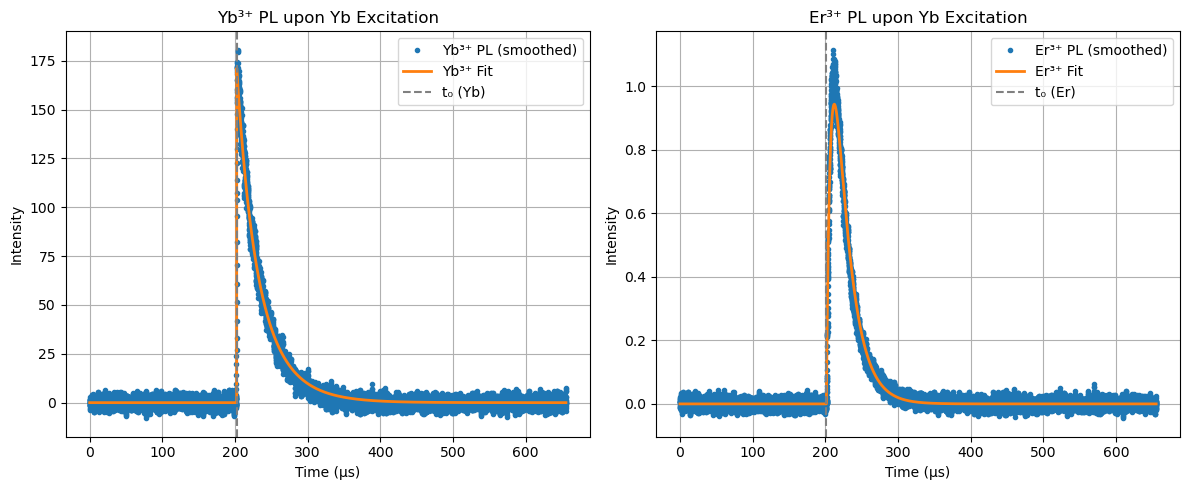

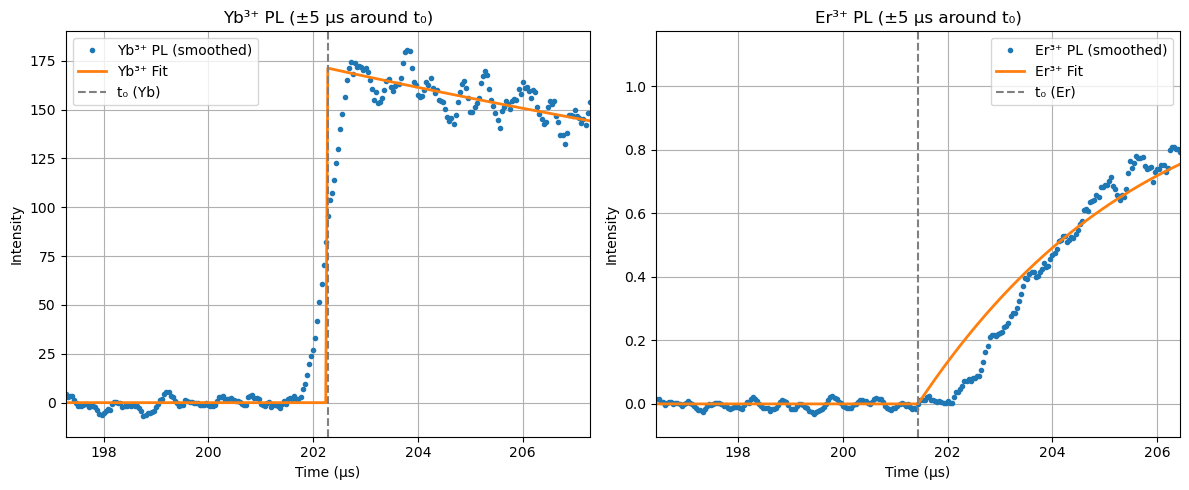

✅ CSV saved: C:\Users\Jacob\Downloads\Yb_Er_PL_fit_output.csv
RMSE_Yb (windowed) = 12.462 over N=1250
RMSE_Er (windowed) = 0.0820973 over N=1250


In [98]:
# One-sentence description: Joint Yb→Er PL fit (unchanged) with equalized per-trace weighting in residuals.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.signal import savgol_filter

# =========================
# USER INPUTS
# =========================
# params = [A1,   B,   k_Yb,     k_Er,     k_ET,  t0_yb, t0_er]
p0 = [3000, 62, 0.0243, 0.155, 0.026, 202, 202.04]
bounds = (
    [2500, 30, 0.024299, 0.15499, 0.020, 200, 200],
    [3500, 80, 0.0243001, 0.155001, 0.040, 205, 205]
)

# Dimer fractions (physical counts, not exciton populations)
f_YbEr = 0.49
f_YbYb = 0.325

# === Fitting controls ===
N_STARTS = 10      # number of random restarts (increase for tougher fits)
RNG_SEED = None    # set None for different results each run

# =========================
# User paths
# =========================
file_path_yb = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\ErYb Yb PL.csv"
file_path_er = r"C:\Users\Jacob\Dropbox\Career_and_Education\Grad_School\Research (DB)\Thesis\YbYb cluster\ErYb Er PL.csv"
out_csv      = r"C:\Users\Jacob\Downloads\Yb_Er_PL_fit_output.csv"

# =========================
# Plot smoothing controls (plotting only; FITS USE RAW DATA)
# =========================
SMOOTH_ON = True
WIN_YB, POLY_YB = 11, 2   # odd window; poly < window
WIN_ER, POLY_ER = 11, 2

# =========================
# Fit-quality windows (used ONLY for RMSE/metrics, not for fitting)
# =========================
FIT_RANGE_YB = (200, 275)    # [tmin, tmax) half-open
FIT_RANGE_ER = (200, 275)    # [tmin, tmax) half-open
EPS = 1e-12

def _sg(y, w, p):
    w = int(max(3, min(w, len(y) - (1 - len(y) % 2))))
    if w % 2 == 0: w -= 1
    p = max(0, min(p, w - 1))
    return savgol_filter(y, window_length=w, polyorder=p, mode="interp")

# =========================
# Load data (CSV with columns: Time,Intensity; skip header row)
# =========================
data_yb = pd.read_csv(file_path_yb, sep=",", header=None, names=["Time", "Intensity"], skiprows=1)
data_er = pd.read_csv(file_path_er, sep=",", header=None, names=["Time", "Intensity"], skiprows=1)

t_yb = data_yb["Time"].values.astype(float)
y_yb = data_yb["Intensity"].values.astype(float)
t_er = data_er["Time"].values.astype(float)
y_er = data_er["Intensity"].values.astype(float)

# For plotting only
y_yb_plot = _sg(y_yb, WIN_YB, POLY_YB) if SMOOTH_ON else y_yb
y_er_plot = _sg(y_er, WIN_ER, POLY_ER) if SMOOTH_ON else y_er

# =========================
# Models (Yb model: two exponentials with your prefactors)
# =========================
def model_yb(t, A1, A2, k_Yb, k_ET, t0_yb):
    dt = t - t0_yb
    y = k_Yb*A1*np.exp(-(k_Yb + k_ET) * dt) + k_Yb*A2 * np.exp(-k_Yb * dt)
    y[dt < 0] = 0.0
    return y

def model_er(t, B, k_Er, k_Yb, k_ET, t0_er):
    dt = t - t0_er
    dt_clip = dt.copy()
    dt_clip[dt_clip < 0] = 0.0
    denom = k_Er - (k_Yb + k_ET)
    denom = np.where(np.abs(denom) < 1e-12, 1e-12, denom)
    y = k_Er*B * (k_ET / denom) * (np.exp(-(k_Yb + k_ET) * dt_clip) - np.exp(-k_Er * dt_clip))
    y[dt < 0] = 0.0
    return y

# =========================
# Residuals (constant length; only t within ranges contributes)
# =========================
def residuals(params, t_yb, y_yb, t_er, y_er):
    # params = [A1, B, k_Yb, k_Er, k_ET, t0_yb, t0_er]
    A1, B, k_Yb, k_Er, k_ET, t0_yb, t0_er = params
    # composition constraint: A2 = (2*f_YbYb/f_YbEr) * A1   (per-Yb excitation)
    A2 = (2.0 * f_YbYb / f_YbEr) * A1

    yb_model = model_yb(t_yb, A1, A2, k_Yb, k_ET, t0_yb)
    er_model = model_er(t_er, B, k_Er, k_Yb, k_ET, t0_er)

    # half-open window masks
    m_yb = (t_yb >= FIT_RANGE_YB[0] - EPS) & (t_yb < FIT_RANGE_YB[1] - EPS)
    m_er = (t_er >= FIT_RANGE_ER[0] - EPS) & (t_er < FIT_RANGE_ER[1] - EPS)
    w_yb = m_yb.astype(float)
    w_er = m_er.astype(float)

    # ===== minimal equal-contribution weighting per trace (std in window, normalize by sqrt(N)) =====
    Nyb, Ner = int(m_yb.sum()), int(m_er.sum())
    wyb = 1.0 / (np.std(y_yb[m_yb]) + EPS) / np.sqrt(max(Nyb, 1))
    wer = 1.0 / (np.std(y_er[m_er]) + EPS) / np.sqrt(max(Ner, 1))

    return np.concatenate([
        wyb * (yb_model - y_yb) * w_yb,
        wer * (er_model - y_er) * w_er
    ])

# =========================
# Initial guesses & bounds
# =========================
lower = np.array(bounds[0], float)
upper = np.array(bounds[1], float)
rng = np.random.default_rng(RNG_SEED)

best = None
for i in range(N_STARTS):
    x0 = np.array(p0, float) if i == 0 else lower + rng.random(len(p0)) * (upper - lower)
    res_i = least_squares(
        residuals, x0=x0, bounds=bounds,
        args=(t_yb, y_yb, t_er, y_er),
        max_nfev=10000, ftol=1e-12, xtol=1e-12, gtol=1e-12,
        loss='soft_l1', f_scale=1.0
    )
    if (best is None) or (res_i.cost < best.cost):
        best = res_i

res = best

# === Extract params and derive A2 for outer scope ===
A1, B, k_Yb, k_Er, k_ET, t0_yb, t0_er = res.x
A2 = (2.0 * f_YbYb / f_YbEr) * A1

# Lifetimes
tau_Yb = 1.0 / k_Yb
tau_Er = 1.0 / k_Er
tau_ET = 1.0 / k_ET

print("=== Fitted Parameters (with A2 = (2 f_YbYb / f_YbEr) * A1) ===")
print(f"A1     = {A1:.3f}")
print(f"A2     = {A2:.3f}  (derived)")
print(f"B      = {B:.3f}")
print(f"k_Yb   = {k_Yb:.6f} µs⁻¹ → τ_Yb = {tau_Yb:.3f} µs")
print(f"k_Er   = {k_Er:.6f} µs⁻¹ → τ_Er = {tau_Er:.3f} µs")
print(f"k_ET   = {k_ET:.6f} µs⁻¹ → τ_ET = {tau_ET:.3f} µs")
print(f"t0_Yb  = {t0_yb:.3f} µs")
print(f"t0_Er  = {t0_er:.3f} µs")

# =========================
# Fits and plots
# =========================
yb_fit = model_yb(t_yb, A1, A2, k_Yb, k_ET, t0_yb)
er_fit = model_er(t_er, B, k_Er, k_Yb, k_ET, t0_er)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(t_yb, y_yb_plot, 'o', ms=3, label='Yb³⁺ PL (smoothed)' if SMOOTH_ON else 'Yb³⁺ PL')
plt.plot(t_yb, yb_fit, '-', lw=2, label='Yb³⁺ Fit')
plt.axvline(t0_yb, color='gray', ls='--', label='t₀ (Yb)')
plt.title("Yb³⁺ PL upon Yb Excitation")
plt.xlabel("Time (µs)"); plt.ylabel("Intensity")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t_er, y_er_plot, 'o', ms=3, label='Er³⁺ PL (smoothed)' if SMOOTH_ON else 'Er³⁺ PL')
plt.plot(t_er, er_fit, '-', lw=2, label='Er³⁺ Fit')
plt.axvline(t0_er, color='gray', ls='--', label='t₀ (Er)')
plt.title("Er³⁺ PL upon Yb Excitation")
plt.xlabel("Time (µs)"); plt.ylabel("Intensity")
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

# === Zoomed-in plots around t0 (±5 µs) ===
plt.figure(figsize=(12,5))

# Yb zoom
plt.subplot(1,2,1)
plt.plot(t_yb, y_yb_plot, 'o', ms=3, label='Yb³⁺ PL (smoothed)' if SMOOTH_ON else 'Yb³⁺ PL')
plt.plot(t_yb, yb_fit, '-', lw=2, label='Yb³⁺ Fit')
plt.axvline(t0_yb, color='gray', ls='--', label='t₀ (Yb)')
plt.xlim(t0_yb - 5, t0_yb + 5)
plt.title("Yb³⁺ PL (±5 µs around t₀)")
plt.xlabel("Time (µs)"); plt.ylabel("Intensity")
plt.legend(); plt.grid(True)

# Er zoom
plt.subplot(1,2,2)
plt.plot(t_er, y_er_plot, 'o', ms=3, label='Er³⁺ PL (smoothed)' if SMOOTH_ON else 'Er³⁺ PL')
plt.plot(t_er, er_fit, '-', lw=2, label='Er³⁺ Fit')
plt.axvline(t0_er, color='gray', ls='--', label='t₀ (Er)')
plt.xlim(t0_er - 5, t0_er + 5)
plt.title("Er³⁺ PL (±5 µs around t₀)")
plt.xlabel("Time (µs)"); plt.ylabel("Intensity")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# =========================
# Save merged output
# =========================
out = pd.DataFrame({
    "Time_Yb": t_yb,
    "Yb_Data": y_yb,
    "Yb_Data_Smoothed": y_yb_plot,
    "Yb_Fit": yb_fit,
    "Time_Er": t_er,
    "Er_Data": y_er,
    "Er_Data_Smoothed": y_er_plot,
    "Er_Fit": er_fit
})
out.to_csv(out_csv, index=False)
print(f"CSV saved: {out_csv}")

# =========================
# Fit-quality metrics over the specified ranges
# =========================
m_yb = (t_yb >= FIT_RANGE_YB[0] - EPS) & (t_yb < FIT_RANGE_YB[1] - EPS)
m_er = (t_er >= FIT_RANGE_ER[0] - EPS) & (t_er < FIT_RANGE_ER[1] - EPS)
assert yb_fit[m_yb].shape == y_yb[m_yb].shape
assert er_fit[m_er].shape == y_er[m_er].shape

rmse_yb = np.sqrt(np.mean((yb_fit[m_yb] - y_yb[m_yb])**2)) if m_yb.any() else np.nan
rmse_er = np.sqrt(np.mean((er_fit[m_er] - y_er[m_er])**2)) if m_er.any() else np.nan

print(f"RMSE_Yb (range) = {rmse_yb:.6g} over N={int(m_yb.sum())}")
print(f"RMSE_Er (range) = {rmse_er:.6g} over N={int(m_er.sum())}")
